In [ ]:
!rm -rf green_seg

In [ ]:
!unzip /content/drive/MyDrive/datasets/2307_em/green_seg2.zip -d .

Archive:  /content/drive/MyDrive/datasets/2307_em/green_seg2.zip
  inflating: ./green_seg/1.jpg       
  inflating: ./green_seg/1_.jpg      
  inflating: ./green_seg/a.jpg       
  inflating: ./green_seg/a_.jpg      
  inflating: ./green_seg/asdf.jpg    
  inflating: ./green_seg/asdf_.jpg   
  inflating: ./green_seg/bb.jpg      
  inflating: ./green_seg/bb_.jpg     
  inflating: ./green_seg/dst_giseok.jpg  
  inflating: ./green_seg/dst_giseok_.jpg  
  inflating: ./green_seg/qq.jpg      
  inflating: ./green_seg/qq_.jpg     
  inflating: ./green_seg/r.jpg       
  inflating: ./green_seg/r_.jpg      
  inflating: ./green_seg/w.jpg       
  inflating: ./green_seg/w_.png      


In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
a = np.array([[1, 2], [3, 4], [5, 6]])
# a[[True, False, True], :] = [[10, 20], [30, 40]]#형태를 맞춰서 집어넣을 수 있고
a[[True, False, True]] = [20, 50]
a

array([[20, 50],
       [ 3,  4],
       [20, 50]])

In [ ]:
a = np.array([1, 2, 3])
a[[True, False, True]] = 30

In [ ]:
#a가 3차원이라면??
a[ True,False 행렬이 2차원으로 들오옥...  , :]



In [ ]:
#error fix
seg = cv2.imread('green_seg/1_.jpg')
seg[np.all(seg == [1, 255, 0], axis=2), :] = [0, 255, 0]
cv2.imwrite('green_seg/1_.jpg', seg)

True

In [ ]:
images = []
truths = []
for root, dirs, filenames in os.walk('green_seg'):
    for filename in filenames:
        first, last = os.path.splitext(filename)
        if first[-1] != '_':
            continue

        image_path = os.path.join(root, first[:-1] + '.jpg')
        image = cv2.imread(image_path)
        if image is None:
            print(image_path)
            continue
        images.append(image)

        print(filename)

        truth_path = os.path.join(root, filename)
        seg = cv2.imread(truth_path)
        seg_bin = np.all(seg == [0, 255, 0], axis=2) | np.all(seg == [1, 255, 0], axis=2)
        truths.append(seg_bin)

len(images), len(truths)


asdf_.jpg
1_.jpg
r_.jpg
dst_giseok_.jpg
qq_.jpg
bb_.jpg
a_.jpg
w_.png


(8, 8)

In [ ]:
def model(sample):
    hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    segment = (34 < h) & (h < 65) & (s > 70) & (v > 50)
    return segment

In [ ]:
segments = []
for image in images:
    segment = model(image)
    # cv2_imshow(segment * 255)
    segments.append(segment)

for segment, truth in zip(segments, truths):
    acc = np.mean(segment == truth)
    print(acc)


0.6174228395061728
0.9801736111111111
0.935054012345679
0.9270273919753086
0.9757195216049382
0.627590663580247
0.829158950617284
0.9526543209876543


In [ ]:
seg = segments[1].astype(np.uint8)
contours, hierarchy = cv2.findContours(seg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(contours)
hierarchy = hierarchy[0]

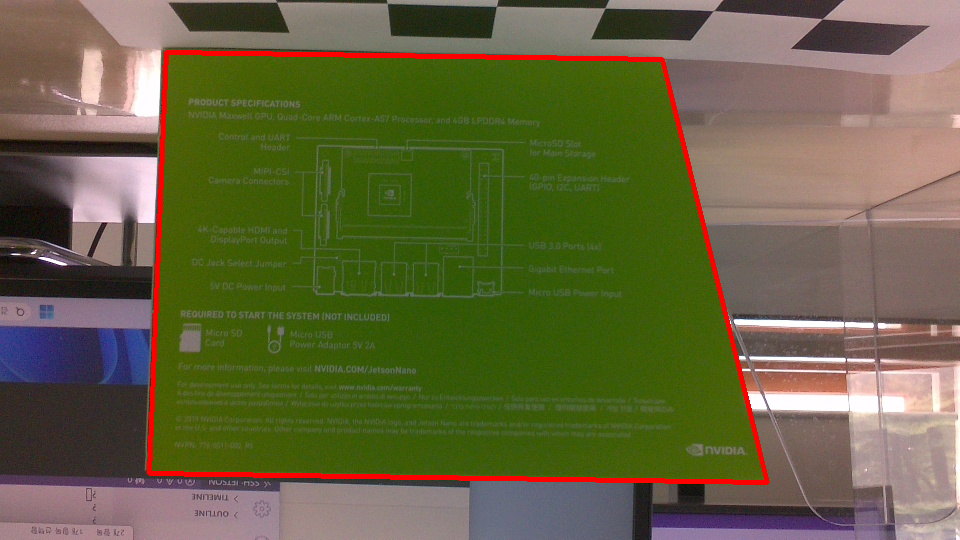

In [ ]:
dst = images[1].copy()
max_arc_len = 0
max_contour = contours[0]
for i in  range(len(contours)):
    hie = hierarchy[i]
    if hie[3] != -1:
        continue
    contour = contours[i]
    arc_len = cv2.arcLength(contour, True)
    if arc_len < 100:
        continue

    ap_con = cv2.approxPolyDP(contour, 30, True, cv2.CHAIN_APPROX_SIMPLE)
    contours[i] = ap_con

    if arc_len > max_arc_len:
        max_arc_len = arc_len
        max_contour = ap_con

cv2.drawContours(dst, [max_contour], 0, (0, 0, 255), 3)
cv2_imshow(dst)

In [ ]:
max_contour

array([[[166,  52]],

       [[149, 473]],

       [[767, 482]],

       [[662,  59]]], dtype=int32)

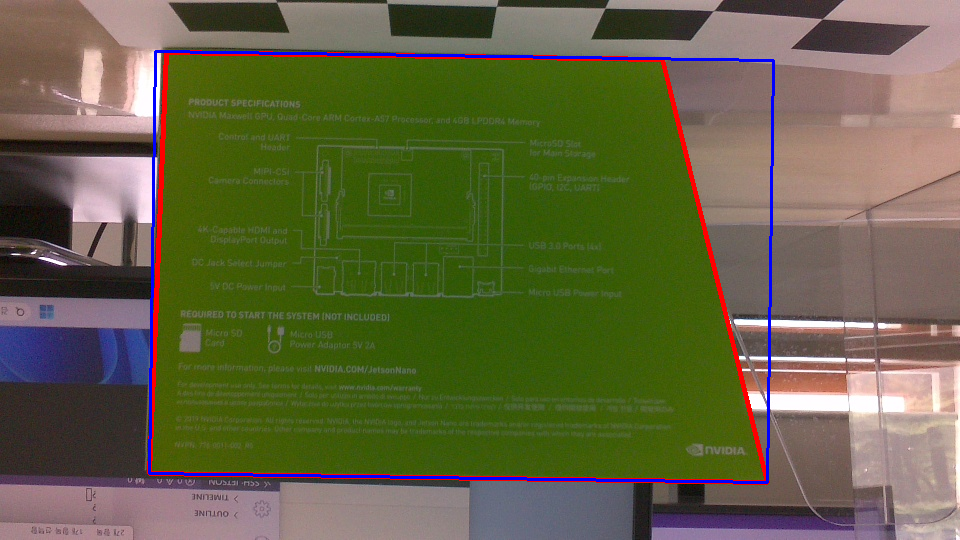

In [ ]:
rect = cv2.minAreaRect(max_contour)
rect
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(dst,[box],0,(255,0,0),2)
cv2_imshow(dst)

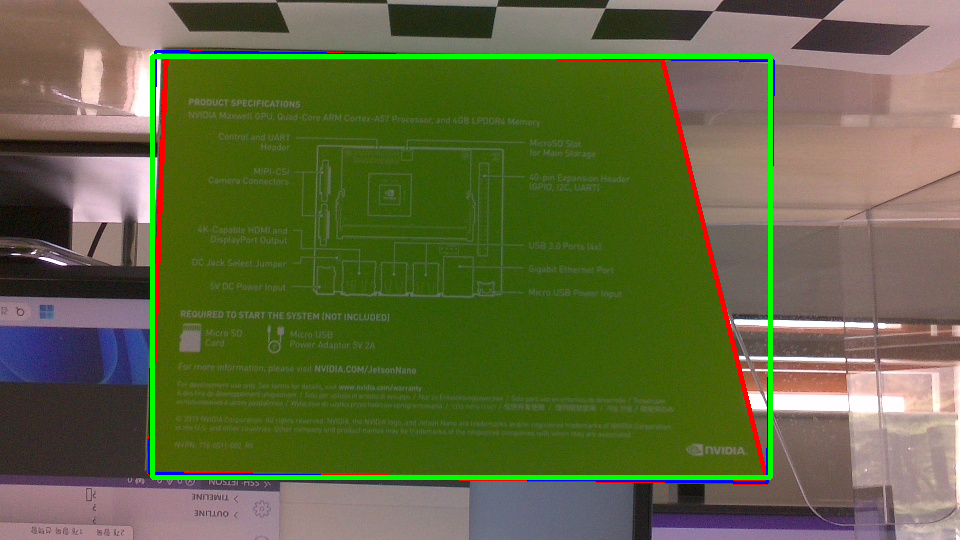

In [ ]:
(cx, cy), (bw, bh), angle = rect
x1 = int(cx - bw / 2)
x2 = int(cx + bw / 2)
y1 = int(cy - bh / 2)
y2 = int(cy + bh / 2)
cv2.rectangle(dst, (x1, y1), (x2, y2), (0, 255, 0), 3)
cv2_imshow(dst)

box_width = max(bh, bw)

# 정리

In [ ]:
#image -> segment -> contour -> max_con -> rotated_rect
#image = cv2.imread('green_seg/a.jpg')
image = np.zeros((480, 640, 3), dtype=np.uint8)
def get_box_width(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    segment = (34 < h) & (h < 65) & (s > 50) & (v > 30) #bool
    segment = segment.astype(np.uint8) #uint8
    contours, hierarchy = cv2.findContours(segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(contours)
    if hierarchy is None:
        return 0
    hierarchy = hierarchy[0]
    max_arc_len = 0
    max_contour = contours[0]
    for i in  range(len(contours)):
        hie = hierarchy[i]
        if hie[3] != -1:
            continue
        contour = contours[i]
        arc_len = cv2.arcLength(contour, True)
        if arc_len < 100:
            continue

        ap_con = cv2.approxPolyDP(contour, 30, True, cv2.CHAIN_APPROX_SIMPLE)
        contours[i] = ap_con

        if arc_len > max_arc_len:
            max_arc_len = arc_len
            max_contour = ap_con
    # dst = image.copy()
    # cv2.drawContours(dst, [max_contour], 0, (0, 0, 255), 3)
    # cv2_imshow(dst)

    rect = cv2.minAreaRect(max_contour)
    (cx, cy), (bw, bh), angle = rect
    box_width = max(bw, bh)
    return box_width
box_width = get_box_width(image)

cv2_imshow(image)

TypeError: ignored

In [ ]:
hierarchy

NameError: ignored

In [ ]:
# 297 = R / box_width
R = 297 * box_width

#예를들어서 box_width == 300
d = R / 300
d

605.4003479003907

In [ ]:
R

181620.1043701172

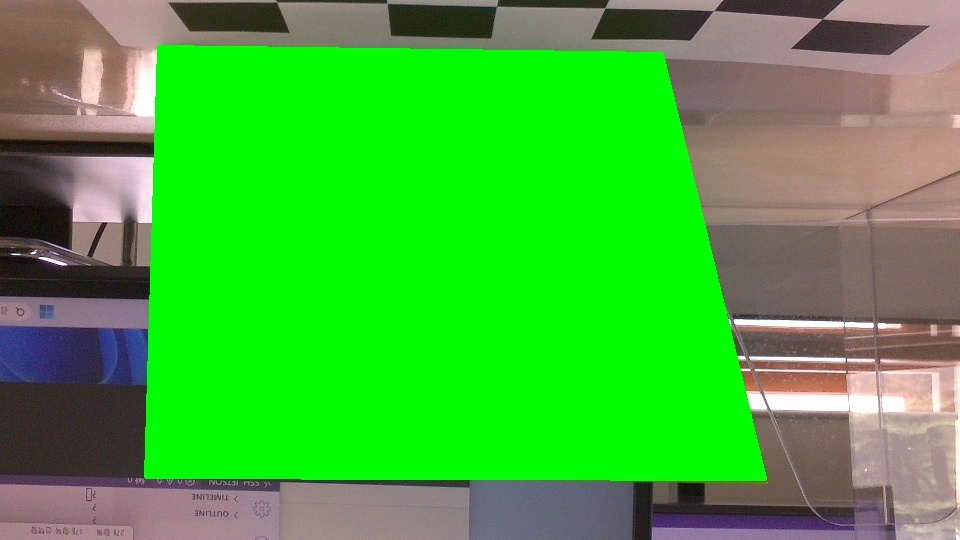

In [ ]:
seg = cv2.imread('green_seg/1_.jpg')
cv2_imshow(seg)

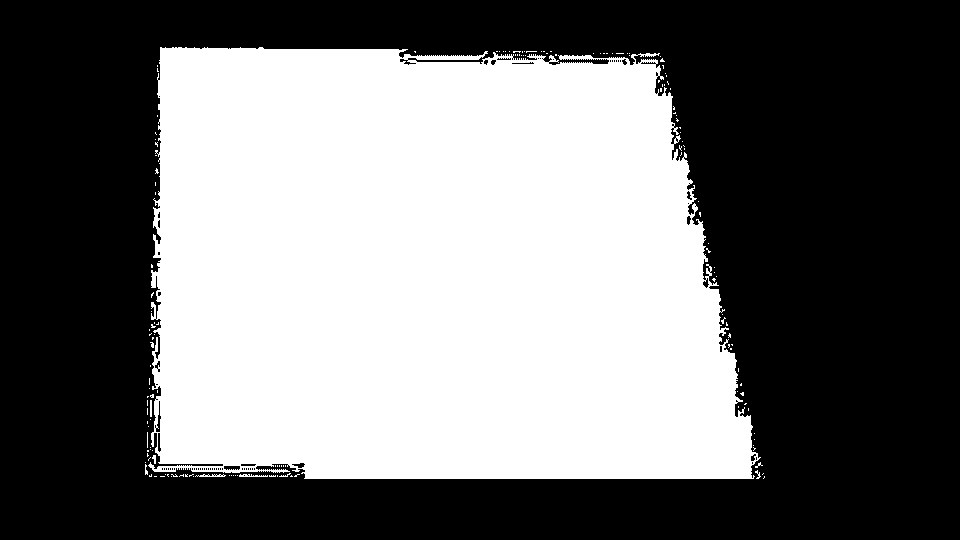

True

In [ ]:
# seg[np.all(seg == [1, 255, 0], axis=2), :] = [0, 255, 0]
cv2.imwrite('green_seg/1_.jpg', seg)
seg_bin = np.all(seg == [0, 255, 0], axis=2)
cv2_imshow(seg_bin * 255)



# 박스 유무 검출

In [ ]:
#samlples = [(image, 1 or 0), (image, 1 or 0), (image, 1 or 0), ...]
samples = []

for root, dirs, files in os.walk('images'):
    print('------', root, '------')
    print('dirs:', dirs)
    print('files:', files)

    if 'neg' in root:
        cat = 0
    elif 'pos' in root:
        cat = 1
    else:
        continue

    for file in files:
        path = os.path.join(root, file)
        image = cv2.imread(path)
        if image is None:
            continue
        samples.append((image, cat))

print('samples : ', len(samples))

------ images ------
dirs: ['sy', 'images', 'neg', 'images_╝█╝Ў┐м', 'pos']
files: []
------ images/sy ------
dirs: ['images']
files: []
------ images/sy/images ------
dirs: ['neg', 'pos']
files: []
------ images/sy/images/neg ------
dirs: []
files: ['1361.jpg', '1636.jpg', '1397.jpg', '1490.jpg', '1575.jpg', '1721.jpg', '1159.jpg', '1712.jpg', '1756.jpg', '1798.jpg', '1255.jpg', '1531.jpg', '1312.jpg', '1445.jpg', '1189.jpg']
------ images/sy/images/pos ------
dirs: []
files: ['714.jpg', '467.jpg', '769.jpg', '615.jpg', '886.jpg', '1042.jpg', '820.jpg', '451.jpg', '569.jpg', '588.jpg', '537.jpg', '987.jpg', '673.jpg']
------ images/images ------
dirs: ['neg', 'pos']
files: []
------ images/images/neg ------
dirs: []
files: ['122.jpg', '285.jpg', '124.jpg', '292.jpg', '115.jpg', '125.jpg']
------ images/images/pos ------
dirs: []
files: ['182.jpg', '228.jpg', '156.jpg', '218.jpg', '226.jpg', '28.jpg']
------ images/neg ------
dirs: []
files: ['151.jpg', '235.jpg', '259.jpg', '314.jpg', 

In [ ]:
# model
def model(sample):
    hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    segment = (34 < h) & (h < 65) & (s > 70) & (v > 50)
    H, W, _ = sample.shape
    p = segment.sum() / (H * W)
    return p

In [ ]:
np.linspace(0, 10, 11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
#
probs = []
for sample, truth in samples:
    p = model(sample)
    probs.append(p)

thres_list = []
acc_list = []
for thres in np.linspace(0.01, 0.4, 1000):
    total = 0
    for p, (sample, truth) in zip(probs, samples):
        pred = int(p > thres)
        if pred == truth:
            total += 1
    acc = total / len(samples)

    acc_list.append(acc)
    thres_list.append(thres)


In [ ]:
# 모든 샘플에 대해서 모델을 적용한다.
# 그 결과로 probs(모델 결과 모음) 를 가져온다.

#thre를 다양하게 적용해서 acc를 확인한다.
#    acc는 모든 probs에 대해서 thres를 적용한 결과이다.
#    (thres, acc) 둘을 각각 리스트에 저장해야 한다.

probs = []
for sample, _ in samples:
    prob = model(sample)
    probs.append(prob)


probs = [model(sample) for sample, truth in samples]
probs = np.array(probs)
truths = np.array([truth for sample, truth in samples])

thres_list = []
acc_list = []
for thres in np.linspace(0.01, 0.4):
    pred = probs > thres
    acc = (pred == truths).mean()

    thres_list.append(thres)
    acc_list.append(acc)

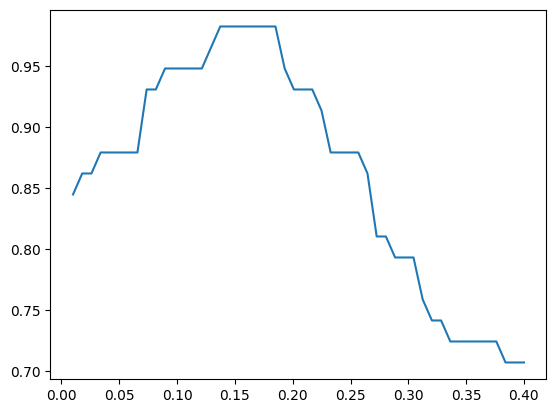

In [ ]:
import matplotlib.pyplot as plt
plt.plot(thres_list, acc_list, '-')